# Problem Analyser by W4

* By this notebook, it is possible to evaluate how difficult your problem is.

* You have to input your nonlinear system equations.

## Caution

* Python version may give a wrong analysis due to the precision issue.

* There are three reasons when you fails to obtain the answer you want.
1. (No response from the W4 method) : The dimension of your system is too large to decompose the Jacobian matrix, which in general scales as $N^3$ where $N$ is the dimension of the system similar to the Newton-Raphson method. 
2. (Getting solution which is not what you want) : There are several solutions(including non-physical solution) in your system and the current initial guess is close to other solution.
3. (Giving Divergence or Not a Number) : Because your Jacobian matrix is ill-conditioned or singular, the iteration process will be terminated.

# Package Inclusion
* Sympy :: To define the set of nonlinear equations
* Numpy :: For iterative solver
* Scipy :: To use Linear solver
* Matplotlib :: For Basin figure

In [1]:
import sympy as sy;
import numpy as np;
from numpy import cos,sin,pi;
from scipy import linalg;
import matplotlib.pyplot as plt;

# Parameter Setup
For the W4 method, we define
* dim : dimension of system
* dtau : $\Delta\tau$ for evolution
* errmax : Criterion of error to stop iteration
* itermax : Maximum iteration.

In [2]:
dim=2;

In [3]:
dtau=0.5;
errmax = pow(10,-4);
itermax = pow(10,3);

In [4]:
### Variables
### x[1], x[2], x[3], ... , x[dim]
### 
x = []
for i in range(0,dim):
    vname = 'x[' + str(i) +']';
    x.append(sy.symbols(vname));

# Definition of Source in the Sympy style
* **F**(**x**) : System of nonlinear equations
* |**F**(**x**)| : Absolute components
* J : Jacobian matrix $\partial$ **F** / $\partial$ **x**

In [5]:
### Source
### f[0], f[1], f[2], ... , f[dim-1]
### So-called Rosenbrock Problem 
###   in the standard test problem for optimization problem
f = [];
f.append( (10*(x[1] -x[0]**2)) );
f.append( (1 -x[0]) );


In [6]:
# input source
def calc_source(x,f):

### Summation of absolute values of all terms in each equation
###  to compare the error with the typical value of each equation
    fa = [];
    for j in range(dim):
        tmp = 0;
        for i in range(len(f[j].args)):
            tmp = tmp + abs(f[j].args[i]);
        fa.append(tmp);        

### Definition of variables, sources, absolute sources(x, F, |F|) as vector
    v = sy.Matrix([x]).transpose();
    F = sy.Matrix([f]).transpose();
    Fa = sy.Matrix([fa]).transpose();
    
### Analytic calculation of Jacobian(dim x dim Matrix)
    J = sy.Matrix();
    for i in range(dim):
        J = J.col_insert(i,F.diff(x[i]));    

### From Sympy to Numpy
    arg = v.transpose();
    vn = sy.lambdify(arg, v, "numpy")
    Fn = sy.lambdify(arg, F, "numpy")
    Fan = sy.lambdify(arg, Fa, "numpy")
    Jacn = sy.lambdify(arg, J, "numpy")        
        
    return vn,Fn,Fan,Jacn;

In [7]:
vn, Fn, Fan, Jacn = calc_source(x,f);

# Definition :: W4LH method

In [8]:
### Analysis by the W4 method with LH decomposition
def w4analysis(v,F,Fa,J,ini,dt,itermax,errmax):
    
### Initialization for x and p as v0 and p0
    p0 = np.zeros(dim);
    v0 = v(*ini).transpose()[0];

    evot = [];
    evot = np.append(evot,0);
    evox = np.array([v0]).reshape(1,dim);
    evop = np.array([p0]).reshape(1,dim);
    evolam = [];
    evolam = np.append(evolam,1.0);

    
### Main Iteration Loop
    for i in range(itermax):
        J0=J(*v0);
        F0=F(*v0).transpose()[0].transpose();
        Fa0=Fa(*v0).transpose()[0].transpose();

### Criterion to stop the iteration
### Evaluation of Source F
        err = 0.0;
        for k in range(dim):
            err = max(err,abs(F0[k]/Fa0[k]));
            
        if err < errmax:
            break;

### Decomposition of Jacobian into L and H
        Q, R = linalg.qr(J0.transpose());
        srcp = -2*p0 -linalg.solve(R.transpose(),F0);
        srcx = Q.transpose().dot(p0);
        v0 = v0 +srcx*dt;
        p0 = p0 +srcp*dt;
        evot = np.append(evot,i);
        evox = np.append(evox,np.array([v0]),axis=0);
        evop = np.append(evop,np.array([p0]),axis=0);
        lmin=abs(R[0][0]);
        lmax=abs(R[0][0]);
        for d in range(dim):
            if lmin > abs(R[d][d]):
                lmin = abs(R[d][d]);
            if lmax < abs(R[d][d]):
                lmax = abs(R[d][d]);
                
        evolam = np.append(evolam,lmax/lmin);

    return v0, i, err, evolam, evot, evox, evop

In [9]:
### Initial guess
vini = np.array([]);
vini = np.append(vini, -1.2);
vini = np.append(vini,  1.0);

### Nonlinear Solver by the W4 method
vans, iter, err, lam, t, x, p = w4analysis(vn,Fn,Fan,Jacn,vini,dtau,itermax,errmax);

### Basic information
print("Dimension : ",dim);
print("Initial Condition number : ",lam[1]);
print("Iteration : ",iter,", error : ", err);
if iter < itermax-1:
    print("< Solved. >");
else:
    print("< Failed. >");

Dimension :  2
Initial Condition number :  67.6
Iteration :  31 , error :  6.868207510340494e-05
< Solved. >


In [10]:
### Saving solution during the W4 iteration for figures
solx1 = [];
solx2 = [];
solp1 = [];
solp2 = [];
for i in range(iter+1):
    solx1 = np.append(solx1,x[i][0]);
    solx2 = np.append(solx2,x[i][1]);
    solp1 = np.append(solp1,p[i][0]);
    solp2 = np.append(solp2,p[i][1]);

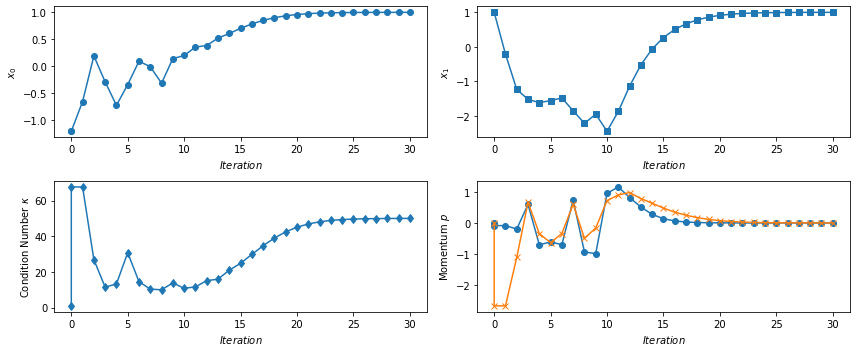

In [11]:
### Figures
fig = plt.figure(figsize=(12,5));
ax1 = fig.add_subplot(2,2,1);
ax1.plot(t,solx1,marker='o');
ax1.set_xlabel("$Iteration$");
ax1.set_ylabel("$x_{0}$");

ax2 = fig.add_subplot(2,2,2);
ax2.plot(t,solx2,marker='s');
ax2.set_xlabel("$Iteration$");
ax2.set_ylabel("$x_{1}$");

ax3 = fig.add_subplot(2,2,3);
ax3.plot(t,lam,marker='d');
ax3.set_xlabel("$Iteration$");
ax3.set_ylabel("Condition Number $\kappa$");

ax4 = fig.add_subplot(2,2,4);
ax4.plot(t,solp1,marker='o');
ax4.plot(t,solp2,marker='x');
ax4.set_xlabel("$Iteration$");
ax4.set_ylabel("Momentum $p$");

fig.tight_layout();

# Comments on Problem Analyzer by W4

## How to see the first basic outputs
* Dimension and initial condition number calculated from the Jacobian matrix are shown.
* Next, the iteration number and the error after the W4 loop are presented.
* The last comment tells us whether the problem was solved from the initial guess.


## How to see the figures
* Left-Upper & Right-Upper figures : The variables are shown as the W4 iteration goes.
* Left-Bottom figure : The condition number as a function of iteration step.
* Right-Bottom figure : The W4 momenta are given as a function of iteration step.


## What we can see
* Thanks to the damping effect in the evolution equation in the W4 method, the variables approach the solution.  
* If the condition number is quite high, the Python version may not give the correct answer due to the round-off error or the matrix decomposition.  (Note that the matrix decomposition in the Python version of the W4 method is different from the FORTRAN90 version in the original paper.) 